In [1]:
import numpy as np
import os
import nibabel as nib
import ants
import brainsss
import matplotlib.pyplot as plt
import psutil
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph
import time
import scipy
import itertools
import random
import h5py
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly = 'fly_087'
func_path = os.path.join(dataset_path, fly, 'func_0')

In [3]:
def load_FDA():
    FDA_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20220301_luke_2_jfrc_affine.nii'
    FDA = np.asarray(nib.load(FDA_file).get_fdata().squeeze(), dtype='float32')
    FDA = ants.from_numpy(FDA)
    FDA.set_spacing((.38,.38,.38))
    FDA_lowres = ants.resample_image(FDA,(2.6,2.6,5),use_voxels=False)
    return FDA, FDA_lowres

In [4]:
def load_synapses_in_FDA():
    synapses_in_FDA_file = '/oak/stanford/groups/trc/data/Yukun/syn_transformed_to_FDA.nii'
    synapses_in_FDA = np.asarray(nib.load(synapses_in_FDA_file).get_fdata().squeeze(), dtype='float32')
    return synapses_in_FDA

In [5]:
def get_hemibrain_bounding_box(synapses_in_FDA):
    # get axes edges in um space of hemibrain withing FDA space
    synapses_in_FDA = ants.from_numpy(synapses_in_FDA)
    synapses_in_FDA.set_spacing((.76,.76,.76))
    synapses_in_FDA_lowres = ants.resample_image(synapses_in_FDA,(2.6,2.6,5),use_voxels=False)
    synapses_in_FDA_lowres = synapses_in_FDA_lowres.numpy()
    
    start = {}
    stop = {}
    for axis, name in zip([0,1,2],['x','y','z']):
        
        start[name] = np.min(np.where(synapses_in_FDA_lowres != 0)[axis])
        start[name] = int(np.floor(start[name]))
        
        stop[name] = np.max(np.where(synapses_in_FDA_lowres != 0)[axis])
        stop[name] = int(np.ceil(stop[name]))
        
    return start, stop

In [6]:
synapses_in_FDA = load_synapses_in_FDA()

In [7]:
synapses_in_FDA = ants.from_numpy(synapses_in_FDA)
synapses_in_FDA.set_spacing((.76,.76,.76))
synapses_in_FDA_lowres = ants.resample_image(synapses_in_FDA,(2.6,2.6,5),use_voxels=False)
synapses_in_FDA_lowres = synapses_in_FDA_lowres.numpy()

In [8]:
FDA, FDA_lowres = load_FDA()

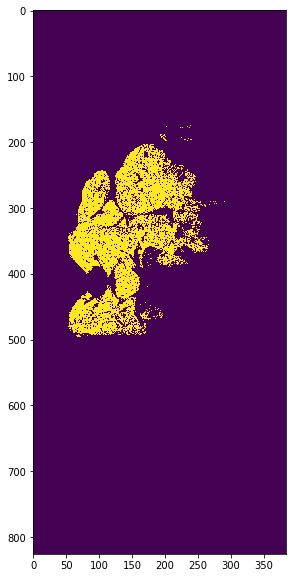

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(synapses_in_FDA[:,:,100]>0)

In [10]:
start, stop = get_hemibrain_bounding_box(synapses_in_FDA.numpy())

In [11]:
FDA_cropped_to_hemi = FDA_lowres[start['x']:stop['x'],
                                 start['y']:stop['y'],
                                 start['z']:stop['z']]

In [12]:
dim_c = {'x': FDA_cropped_to_hemi.shape[0],
         'y': FDA_cropped_to_hemi.shape[1],
         'z': FDA_cropped_to_hemi.shape[2]}

In [13]:
save_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220624_supervoxels_in_FDA'

save_file = os.path.join(save_dir, '20220624_ipsi_turn_corrs.npy')
ipsi_turn_corrs = np.load(save_file)

save_file = os.path.join(save_dir, '20220624_contra_turn_corrs.npy')
contra_turn_corrs = np.load(save_file)

save_file = os.path.join(save_dir, '20220624_fwd_corrs.npy')
fwd_corrs = np.load(save_file)

In [14]:
n_clusters = 5000
clustering_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210128_superv_simul_full_vol"
save_file = os.path.join(clustering_dir, '20220624_cluster_labels_flat.npy')
labels_flat = np.load(save_file)
labels_3d = np.reshape(labels_flat,(dim_c['x'],dim_c['y'],dim_c['z']))

cluster_sizes = []
for cluster in range(n_clusters):
    cluster_sizes.append(len(np.where(labels_flat==cluster)[0]))
background_cluster = np.argmax(cluster_sizes)

labels_3d = labels_3d.astype('float32')
labels_3d[np.where(labels_3d==background_cluster)] = np.nan

#now that we removed background cluster, lets give it to 0 so we can get rid of "0" as well
labels_3d[np.where(labels_3d==0)] = background_cluster
labels_flat = labels_3d.flatten()

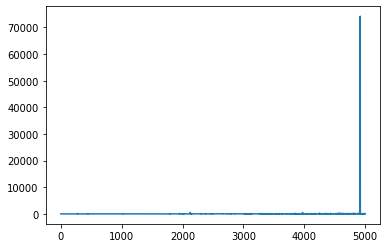

In [15]:
plt.plot(cluster_sizes)

In [16]:
save_file = os.path.join(save_dir, 'adjacent_supervoxel.h5')

with h5py.File(save_file, 'r') as f:
    #print(list(f.keys()))
    adj = f['adjacent_supervoxel'][:]
    
# Feng removed the "0" entry so adding back
adj = np.pad(adj, (1,0), 'constant', constant_values=(0))

# Symmeterize
adj = (adj + adj.T) / 2

In [17]:
adj.shape

(5000, 5000)

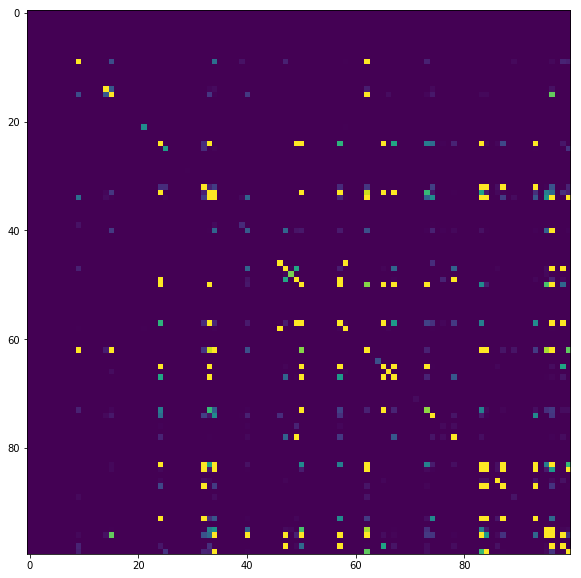

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(adj[:100,:100],vmin=0,vmax=10000)

In [17]:
def clusters_to_3d(neural_signals):
    colored = np.zeros((dim_c['x']*dim_c['y']*dim_c['z']))
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(labels_flat==cluster_num)[0]
        colored[cluster_indicies] = neural_signals[cluster_num]
    colored = np.reshape(colored,(dim_c['x'],dim_c['y'],dim_c['z']))
    return colored

In [17]:
dim_c['x'],dim_c['y'],dim_c['z']

(100, 86, 29)

In [18]:
### clusters

threshold = .2

contra_turn_corrs[np.where(contra_turn_corrs<threshold)] = 0
contra_turn_corrs[np.where(contra_turn_corrs>threshold)] = 1

ipsi_turn_corrs[np.where(ipsi_turn_corrs<threshold)] = 0
ipsi_turn_corrs[np.where(ipsi_turn_corrs>threshold)] = 1

fwd_corrs[np.where(fwd_corrs<threshold)] = 0
fwd_corrs[np.where(fwd_corrs>threshold)] = 1

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encount

In [19]:
colored_contra = clusters_to_3d(contra_turn_corrs)
colored_ipsi = clusters_to_3d(ipsi_turn_corrs)
colored_fwd = clusters_to_3d(fwd_corrs)

In [20]:
rgb = np.concatenate((colored_ipsi[...,np.newaxis], colored_contra[...,np.newaxis], colored_fwd[...,np.newaxis]),axis=3)
rgb = np.swapaxes(rgb,0,1)

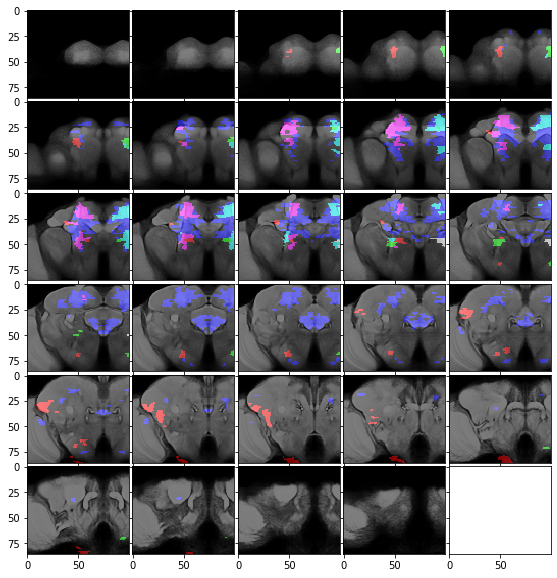

In [21]:
fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_cropped_to_hemi[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(rgb[:,:,z,:], alpha=.5)

In [77]:
FDA_cropped_to_hemi.shape

(100, 86, 29)

In [79]:
2.6*2.6*5

33.800000000000004

In [78]:
100*86*29/2

124700.0

In [73]:
np.sum(labels_3d>0)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


175182

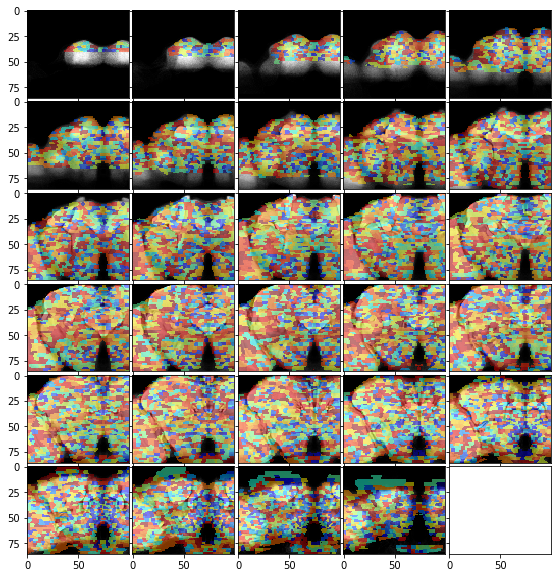

In [22]:
fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_cropped_to_hemi[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(labels_3d[:,:,z].T, alpha=.5, cmap='jet')

In [51]:
np.where(ipsi_turn_corrs)

(array([   0, 1238, 1383, 1622, 1677, 2004, 2016, 2236, 2256, 2312, 2319,
        2345, 2419, 2503, 2632, 2640, 2675, 2733, 2747, 2762, 2999, 3052,
        3192, 3226, 3261, 3324, 3382, 3440, 3466, 3507, 3549, 3658, 3777,
        3846, 3856, 3913, 3957, 4005, 4019, 4112, 4113, 4127, 4246, 4259,
        4264, 4348, 4351, 4579, 4645, 4646, 4666, 4679, 4781, 4784, 4797,
        4800, 4902]),)

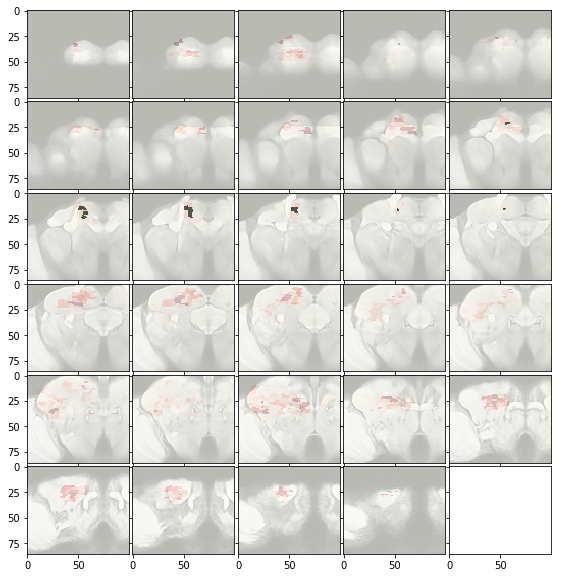

In [373]:
seed_cluster = 4351

visualize_seed = np.zeros(5000)
visualize_seed[seed_cluster] = 1
visualize_seed = clusters_to_3d(visualize_seed)

connectivity = adj[seed_cluster,:]
connectivity = clusters_to_3d(connectivity)

fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_cropped_to_hemi[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(connectivity[:,:,z].T, alpha=.5, cmap='Reds')
    grid[z].imshow(visualize_seed[:,:,z].T, alpha=.5, cmap='Greens')

In [23]:
temp = np.zeros(5000)
temp[supervoxels_yes] = 1
temp = clusters_to_3d(temp)

NameError: name 'supervoxels_yes' is not defined

In [ ]:
fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 5), axes_pad=.05)
for z in range(29):
    grid[z].imshow(FDA_cropped_to_hemi[:,:,z].T,cmap='Greys_r')
    grid[z].imshow(temp[:,:,z].T, alpha=.5, cmap='Reds')

# Get Yes sample value

(3288, 3288)


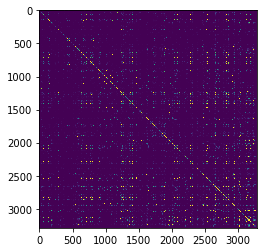

In [367]:
# out = adj[valid_clusters,:]
# out = out[:,valid_clusters]
# print(out.shape)
# plt.imshow(out,vmax=1000000)

In [391]:
# np.percentile(out,90), np.percentile(yes,90)

(17026.5, 4623494.5)

In [364]:
# yes = adj[supervoxels_yes,:]
# yes = yes[:,supervoxels_yes]
# yes.shape
# np.mean(yes)

1680512.814732143

In [372]:
# np.where(adj==np.max(adj))

(array([4351]), array([4351]))

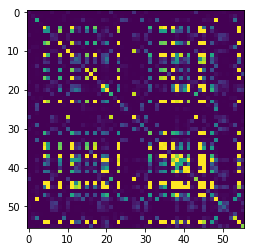

In [370]:
# plt.imshow(yes,vmax=10000000)

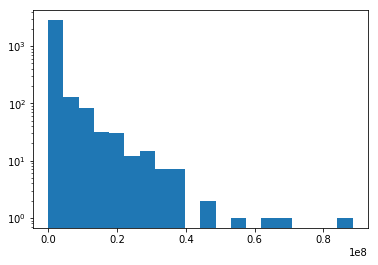

In [369]:
# plt.hist(yes.flatten(),bins=20,log=True);

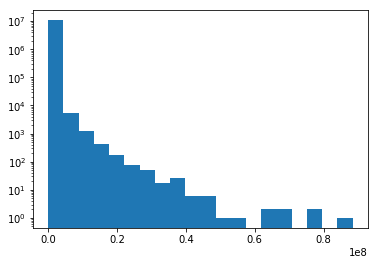

In [368]:
# plt.hist(out.flatten(),bins=20,log=True);

In [355]:
# np.mean(out), np.mean(adj[supervoxels_yes])

26588.027579090227

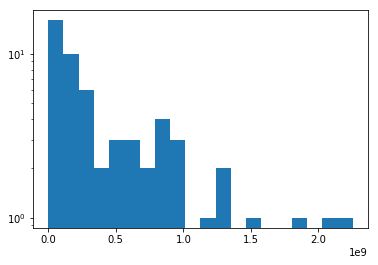

In [337]:
# plt.hist(np.sum(adj,axis=0)[supervoxels_yes],bins=20,log=True);

/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/users/brezovec/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([5.000e+00, 1.300e+01, 3.280e+02, 3.001e+03, 1.138e+03, 3.500e+02,
        1.050e+02, 4.900e+01, 8.000e+00, 2.000e+00]),
 array([-0.16505272, -0.11362855, -0.06220438, -0.01078021,  0.04064397,
         0.09206814,  0.14349231,  0.19491648,  0.24634065,  0.29776483,
         0.349189  ]),
 <a list of 10 Patch objects>)

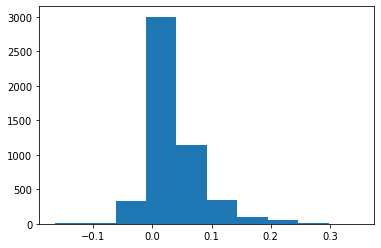

In [16]:
plt.hist(ipsi_turn_corrs)

In [22]:
##############################
### DEFINE YES SUPERVOXELS ###
##############################

threshold = .2
#supervoxels_yes = list(np.where(contra_turn_corrs>threshold)[0])
#supervoxels_yes = list(np.where(fwd_corrs>threshold)[0])
supervoxels_yes = list(np.where(ipsi_turn_corrs>threshold)[0])
print(len(supervoxels_yes))

### get supervoxel_yes pairs which are within the desired centroid distance range ###

centroids = []
for cluster_num in supervoxels_yes:
    xyz_voxel_space = np.asarray(np.where(labels_3d==cluster_num)).mean(axis=-1)
    centroids.append(list(xyz_voxel_space * (2.6,2.6,5)[0]))
centroids = np.asarray(centroids)

yes_distances = []
yes_combs = []
for comb in itertools.combinations(list(range(len(centroids))), 2):
    yes_combs.append(comb)
    id1 = comb[0]; id2 = comb[1]
    
    x_dist = (centroids[id1,0] - centroids[id2,0])**2
    y_dist = (centroids[id1,1] - centroids[id2,1])**2
    z_dist = (centroids[id1,2] - centroids[id2,2])**2
    dist = (x_dist + y_dist + z_dist)**.5
    yes_distances.append(dist)
yes_distances = np.asarray(yes_distances)
print(yes_distances.shape)

56
(1540,)


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [24]:
# data = numpy.random.random(100)
# bins = numpy.linspace(0, 1, 10)
# digitized = np.digitize(data, bins)
# bin_means = [data[digitized == i].mean() for i in range(1, len(bins))]

NameError: name 'numpy' is not defined

In [25]:
bins = np.arange(0, 50+1, 10)
print(bins)
digitized = np.digitize(yes_distances, bins)
bin_cnt = [len(yes_distances[digitized == i]) for i in range(1, len(bins))]
print(bin_cnt)

[ 0 10 20 30 40 50]
[42, 115, 124, 102, 103]


In [83]:
len(yes_distances[digitized == 1])

42

In [89]:
np.sum(bin_cnt)

486

array([ 42., 115., 124., 102., 103.])

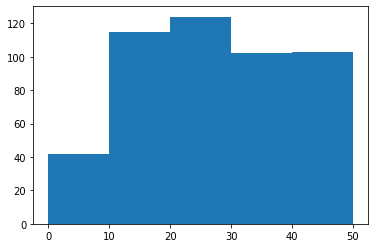

In [26]:
plt.hist(yes_distances,bins=[0,10,20,30,40,50])[0]

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150])

In [100]:
lowers = np.arange(0,150,10)
uppers = np.arange(10,160,10)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140])

In [27]:
######################
### START YES HERE ###
######################

# lowers = [0,50,100,150]
# uppers = [50,100,150,250]
# lowers = [0,50,100]
# uppers = [50,100,250]

lowers = np.arange(0,150,10)
uppers = np.arange(10,160,10)

sub_bin_width = 10 # this will be used to match the distance distribution within each bin

yes_connectivities = []
n_edges = []
for y in range(len(lowers)):
    labels_yes = list(np.where(((yes_distances > lowers[y]) & (yes_distances < uppers[y])))[0])
    n_edges.append(len(labels_yes))
    #labels_yes must first index into 

    yes_sample_connectivity = []
    for i in labels_yes:
        id1 = supervoxels_yes[yes_combs[i][0]]
        id2 = supervoxels_yes[yes_combs[i][1]]
        
        # correct for supervoxel size
        size = cluster_sizes[id1] + cluster_sizes[id2]
        
        yes_sample_connectivity.append(adj[id1,id2]/size)
    # yes_sample_connectivity = np.mean(yes_sample_connectivity)
    # yes_sample_connectivity
#     print(np.mean(yes_sample_connectivity))
#     print(np.percentile(yes_sample_connectivity,50))
    #yes_connectivities.append(np.percentile(yes_sample_connectivity,50))
    yes_connectivities.append(np.mean(yes_sample_connectivity))

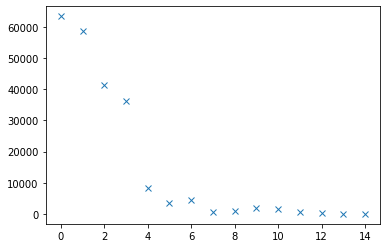

In [28]:
plt.plot(yes_connectivities,'x')

In [467]:
yes_connectivities

[4309637.944444444, 269461.33450704225, 81313.70428893906, 1021.7790697674419]

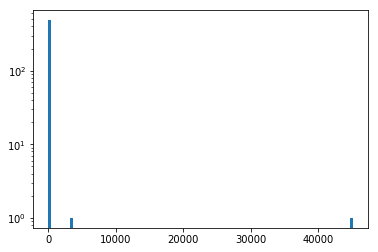

In [312]:
plt.hist(yes_sample_connectivity,bins=100,log=True);

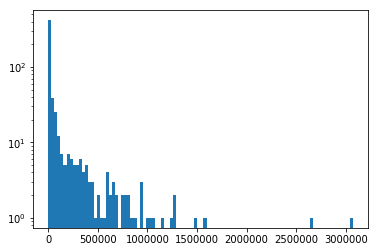

In [247]:
plt.hist(yes_sample_connectivity,bins=100,log=True);

# Get No sample distribution

In [29]:
# get list of supervoxel ids that contain synapses
valid_clusters = list(np.where(np.sum(adj,axis=0) != 0)[0])
valid_clusters.remove(background_cluster)

In [23]:
len(valid_clusters)

3287

In [30]:
valid_clusters.remove(background_cluster)

ValueError: list.remove(x): x not in list

In [91]:
background_cluster

4918

In [92]:
4918 in valid_clusters

False

In [31]:
### get distribution of distances between all supervoxels (VALID! supervoxels)

centroids = []
for cluster_num in valid_clusters:
    xyz_voxel_space = np.asarray(np.where(labels_3d==cluster_num)).mean(axis=-1)
    centroids.append(list(xyz_voxel_space * (2.6,2.6,5)[0]))
centroids = np.asarray(centroids)

combs = []
distances = []
for comb in itertools.combinations(list(range(len(centroids))), 2):
    combs.append(comb)
    id1 = comb[0]; id2 = comb[1]
    
    x_dist = (centroids[id1,0] - centroids[id2,0])**2
    y_dist = (centroids[id1,1] - centroids[id2,1])**2
    z_dist = (centroids[id1,2] - centroids[id2,2])**2
    dist = (x_dist + y_dist + z_dist)**.5
    distances.append(dist)
distances = np.asarray(distances)

### NOW ID1 and ID2 must be used to index into VALID_CLUSTERS

In [32]:
bins = np.arange(0, 50+1, 10)
print(bins)
digitized = np.digitize(yes_distances, bins)
bin_cnt = [len(yes_distances[digitized == i]) for i in range(1, len(bins))]
print(bin_cnt)

[ 0 10 20 30 40 50]
[42, 115, 124, 102, 103]


In [33]:
digitized = np.digitize(distances, bins)
bin_cnt = [len(distances[digitized == i]) for i in range(1, len(bins))]

In [37]:
np.unique(temp)

array([0.])

In [82]:
cluster_sizes

[10,
 6,
 8,
 9,
 12,
 11,
 11,
 13,
 6,
 6,
 9,
 9,
 15,
 8,
 10,
 6,
 6,
 4,
 9,
 9,
 8,
 7,
 13,
 13,
 10,
 8,
 7,
 6,
 6,
 6,
 5,
 12,
 15,
 7,
 14,
 14,
 14,
 6,
 6,
 14,
 8,
 6,
 11,
 13,
 8,
 10,
 6,
 10,
 10,
 12,
 11,
 14,
 17,
 15,
 12,
 12,
 15,
 9,
 14,
 20,
 13,
 8,
 8,
 11,
 7,
 50,
 7,
 11,
 8,
 24,
 24,
 18,
 8,
 8,
 8,
 14,
 5,
 34,
 12,
 10,
 9,
 13,
 6,
 10,
 10,
 8,
 17,
 19,
 9,
 9,
 9,
 12,
 12,
 15,
 11,
 11,
 11,
 10,
 12,
 8,
 8,
 17,
 18,
 21,
 21,
 15,
 14,
 15,
 14,
 8,
 13,
 10,
 10,
 9,
 13,
 11,
 8,
 13,
 18,
 12,
 13,
 13,
 11,
 16,
 16,
 10,
 9,
 11,
 11,
 17,
 19,
 14,
 14,
 9,
 10,
 24,
 14,
 20,
 17,
 16,
 19,
 8,
 8,
 10,
 12,
 9,
 20,
 20,
 14,
 10,
 25,
 12,
 8,
 22,
 19,
 18,
 19,
 15,
 18,
 14,
 14,
 16,
 16,
 15,
 17,
 15,
 10,
 10,
 9,
 16,
 21,
 21,
 9,
 9,
 15,
 15,
 7,
 11,
 11,
 14,
 20,
 21,
 12,
 18,
 17,
 15,
 15,
 15,
 11,
 15,
 15,
 17,
 17,
 10,
 10,
 19,
 19,
 16,
 20,
 20,
 24,
 16,
 25,
 16,
 15,
 15,
 19,
 34,
 14,
 12,
 8,
 8,
 

In [34]:
# get a control list of all supervoxel combos that are within a specified distance from eachother
convert_to_syn_per_micron = 34 #added this 20230619
#Voxel is (2.6,2.6,5), ie 2.6*2.6*5=33.8um^3

bootstrap_num = 1000
no_connectivities = []
for y in range(len(lowers)):
    
    supervoxels_no = ((distances > lowers[y]) & (distances < uppers[y]))

    # now I will want to take a specific number of these combos, randomly, n times
    labels_no = np.where(supervoxels_no)[0]
    sample_size = n_edges[y]
    
    no_connectivities_one_sample = []
    for n in range(bootstrap_num):
        one_sample_set = random.choices(labels_no,k=sample_size)
        sample_connectivity = []
        for i in range(sample_size):
            id1 = combs[one_sample_set[i]][0]
            id2 = combs[one_sample_set[i]][1]
            id1 = valid_clusters[id1]
            id2 = valid_clusters[id2]

            # correct for supervoxel size
            size = cluster_sizes[id1] + cluster_sizes[id2]
            
            sample_connectivity.append(adj[id1,id2]/convert_to_syn_per_micron*size)
        no_connectivities_one_sample.append(np.mean(sample_connectivity))
    no_connectivities.append(np.asarray(no_connectivities_one_sample)/convert_to_syn_per_micron*size)

In [67]:
# # get a control list of all supervoxel combos that are within a specified distance from eachother
# bootstrap_num = 1000
# no_connectivities = []
# for y in range(len(lowers)):
#     supervoxels_no = ((distances > lowers[y]) & (distances < uppers[y]))

#     # now I will want to take a specific number of these combos, randomly, n times
#     labels_no = np.where(supervoxels_no)[0]
#     sample_size = n_edges[y]
    
#     no_connectivities_one_sample = []
#     for n in range(bootstrap_num):
#         one_sample_set = random.choices(labels_no,k=sample_size)
#         sample_connectivity = []
#         for i in range(sample_size):
#             id1 = combs[one_sample_set[i]][0]
#             id2 = combs[one_sample_set[i]][1]
#             id1 = valid_clusters[id1]
#             id2 = valid_clusters[id2]

#             sample_connectivity.append(adj[id1,id2])
#         no_connectivities_one_sample.append(np.mean(sample_connectivity))
#     no_connectivities.append(np.asarray(no_connectivities_one_sample))

Text(0, 0.5, 'Connectivity')

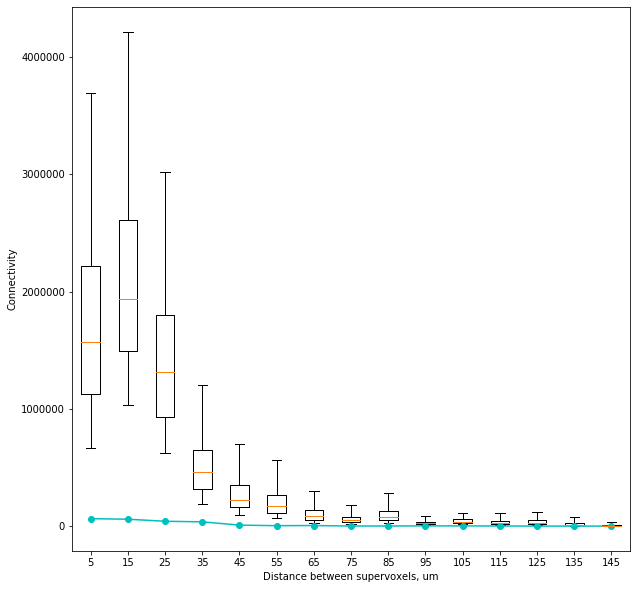

In [35]:
plt.figure(figsize=(10,10))
#plt.plot(no_connectivities,marker='x',linestyle='',color='k');
plt.boxplot(no_connectivities, showfliers=False, whis=(5, 95))
plt.plot(np.arange(1,16,1), yes_connectivities,'o',color='c',linestyle='-')
plt.xticks(np.arange(1,16,1), np.arange(5,160,10));
plt.xlabel('Distance between supervoxels, um')
plt.ylabel('Connectivity')

Text(0, 0.5, 'Connectivity')

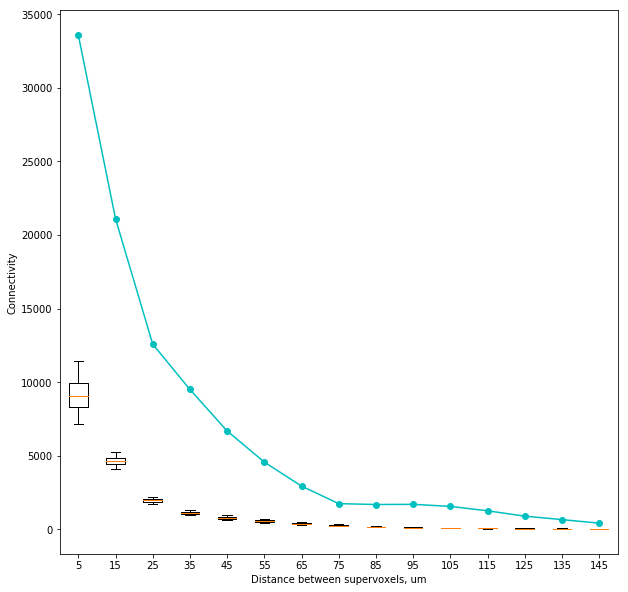

In [175]:
plt.figure(figsize=(10,10))
#plt.plot(no_connectivities,marker='x',linestyle='',color='k');
plt.boxplot(no_connectivities, showfliers=False, whis=(5, 95))
plt.plot(np.arange(1,16,1), yes_connectivities,'o',color='c',linestyle='-')
plt.xticks(np.arange(1,16,1), np.arange(5,160,10));
plt.xlabel('Distance between supervoxels, um')
plt.ylabel('Connectivity')

In [33]:
yes_connectivities_15 = yes_connectivities.copy()

In [30]:
yes_connectivities_2 = yes_connectivities.copy()

In [42]:
yes_connectivities_1 = yes_connectivities.copy()

In [52]:
no_connectivities[0].shape

(1000,)

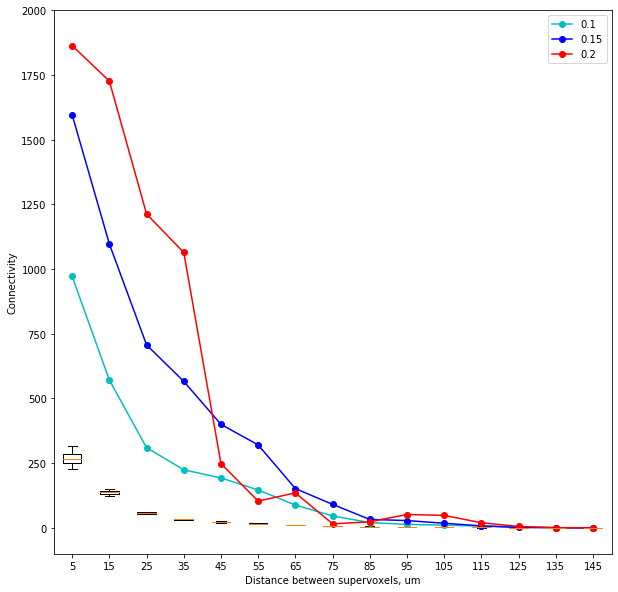

In [65]:
plt.figure(figsize=(10,10))
#plt.plot(no_connectivities,marker='x',linestyle='',color='k');
plt.boxplot(no_connectivities, showfliers=False, whis=(5, 95))
plt.plot(np.arange(1,16,1), np.asarray(yes_connectivities_1)/34,'o',color='c',linestyle='-',label=0.1)
plt.plot(np.arange(1,16,1), np.asarray(yes_connectivities_15)/34,'o',color='b',linestyle='-',label=.15)
plt.plot(np.arange(1,16,1), np.asarray(yes_connectivities_2)/34,'o',color='r',linestyle='-',label=.2)
plt.xticks(np.arange(1,16,1), np.arange(5,160,10));
plt.xlabel('Distance between supervoxels, um')
plt.ylabel('Connectivity')
#plt.ylim(-3000,65000)
plt.ylim(-100,2000)
plt.legend()

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [76]:
20000000 #number of synapses
175182 #num voxels
20000000/(175182)

114.16698062586339

In [152]:
is_sig = []
for i in range(len(yes_connectivities)):
    is_sig.append(np.searchsorted(np.sort(no_connectivities[i]), yes_connectivities[i]) >= 950)

In [153]:
is_sig

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False]

In [139]:
np.arange(1,160,10)

array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151])

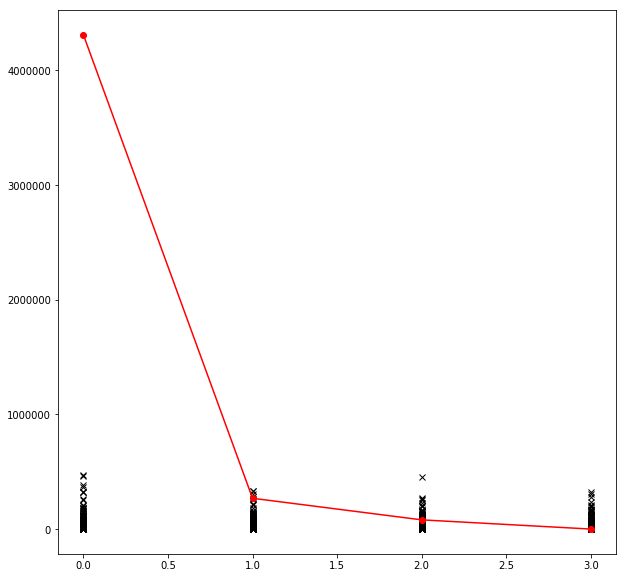

In [510]:
plt.figure(figsize=(10,10))
plt.plot(no_connectivities,marker='x',linestyle='',color='k');
plt.plot(yes_connectivities,'o',color='r',linestyle='-')

In [41]:
yes_connectivities[2]

81313.70428893906

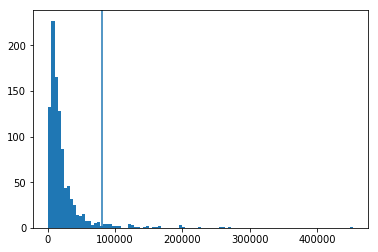

In [500]:
plt.hist(no_connectivities[2],bins=100);
plt.axvline(yes_connectivities[2])

In [491]:
np.sort(no_connectivities[2])

array([  1646.96511628,   2013.1744186 ,   2777.48837209,   3354.29069767,
         3653.34883721,   4104.26744186,   4119.47674419,   4211.40697674,
         4534.51162791,   4724.03488372,   4752.10465116,   5638.91860465,
         5764.25581395,   5858.46511628,   5874.39534884,   6171.65116279,
         6571.61627907,   6572.45348837,   7081.29069767,   7263.6744186 ,
         7371.58139535,   7464.59302326,   7758.30232558,   7915.11627907,
         7957.76744186,   8028.15116279,   8245.40697674,   8590.91860465,
         8722.70930233,   8925.45348837,   8994.93023256,   9004.91860465,
         9059.70930233,   9248.52325581,   9290.27906977,   9510.89534884,
         9656.55813953,  10084.3255814 ,  10202.79069767,  10249.95348837,
        10623.31395349,  10793.76744186,  11186.26744186,  11294.51162791,
        12321.10465116,  13191.34883721,  13402.86046512,  13592.24418605,
        14108.01162791,  14274.3372093 ,  15011.59302326,  15121.52325581,
        16396.56976744,  

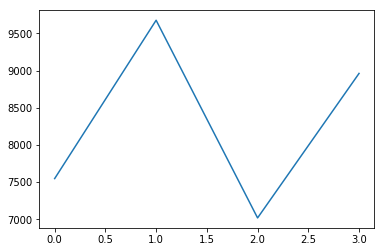

In [473]:
plt.plot(no_connectivities)

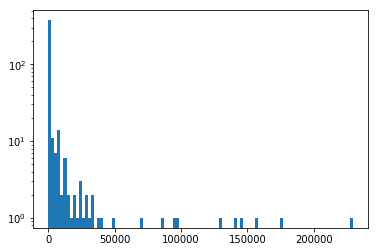

In [302]:
plt.hist(sample_connectivity,bins=100,log=True);

In [230]:
len(labels_yes)

446

In [226]:
labels_yes

[1,
 3,
 9,
 10,
 13,
 14,
 16,
 20,
 22,
 24,
 26,
 30,
 32,
 33,
 34,
 36,
 38,
 42,
 43,
 46,
 47,
 52,
 53,
 56,
 62,
 75,
 77,
 99,
 105,
 106,
 110,
 116,
 120,
 127,
 130,
 131,
 133,
 135,
 139,
 149,
 154,
 159,
 160,
 167,
 180,
 182,
 204,
 210,
 214,
 217,
 219,
 220,
 221,
 222,
 224,
 226,
 228,
 229,
 230,
 232,
 234,
 236,
 240,
 242,
 243,
 244,
 246,
 247,
 248,
 249,
 250,
 252,
 253,
 254,
 256,
 257,
 263,
 267,
 270,
 271,
 272,
 274,
 276,
 278,
 279,
 282,
 290,
 293,
 294,
 296,
 297,
 298,
 299,
 300,
 303,
 304,
 306,
 313,
 315,
 324,
 326,
 336,
 338,
 350,
 357,
 358,
 359,
 363,
 372,
 374,
 384,
 386,
 392,
 398,
 405,
 406,
 407,
 411,
 414,
 415,
 416,
 418,
 420,
 422,
 423,
 426,
 434,
 437,
 438,
 440,
 441,
 442,
 443,
 444,
 447,
 448,
 450,
 457,
 471,
 481,
 495,
 501,
 505,
 508,
 509,
 515,
 517,
 519,
 521,
 525,
 527,
 528,
 529,
 531,
 533,
 537,
 538,
 541,
 542,
 548,
 550,
 551,
 553,
 555,
 557,
 558,
 561,
 565,
 569,
 572,
 573,
 575,

In [ ]:
sample_connectivity = []
for i in range(sample_size):
    id1 = combs[one_sample_set[i]][0]
    id2 = combs[one_sample_set[i]][1]
    id1 = valid_clusters[id1]
    id2 = valid_clusters[id2]
    
    sample_connectivity.append(adj[id1,id2])

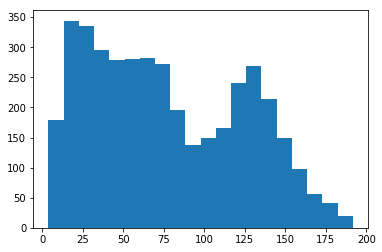

In [183]:
plt.hist(yes_distances,bins=20);


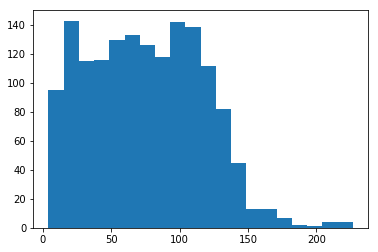

In [56]:
plt.hist(yes_distances,bins=20);
#plt.xlim(0,20)

In [ ]:
# pull from full distribution based on sub-distribution

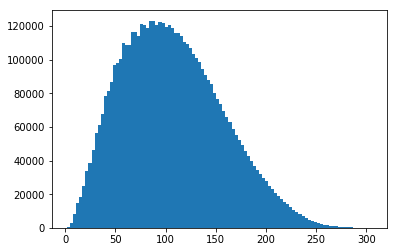

In [47]:
plt.hist(distances,bins=100);

In [190]:
one_sample_set[0]

4812299

In [173]:
adj.T[2335,14]

6938.0

In [160]:
one_sample_set

[4685,
 1660700,
 2313353,
 1963969,
 4125062,
 2937936,
 3607733,
 4702496,
 1653495,
 4655288]

In [162]:
combs[one_sample_set[0]]

(1, 1420)

In [169]:
valid_clusters[1420]

2335